#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**


In [71]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod
import math
from collections import Counter
from typing import List, Dict
import numpy as np
import matplotlib.pyplot as plt

In [72]:
class BayesSkeleton(ABC):
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def _calc_priors(self, train_classes):
        total_samples = len(train_classes)
        for c in np.unique(train_classes):
            self.priors[c] = np.sum(train_classes == c) / total_samples

    def _calc_likelihoods(self, train_features, train_classes):
        for c in self.classes:
            self.likelihoods[c] = {}
            class_features = train_features[train_classes == c]

            for i in range(train_features.shape[1]):
                values, counts = np.unique(class_features[:, i], return_counts=True)

                for value, count in zip(values, counts):
                    # P(X_i = value | Y = c)
                    self.likelihoods[c][(i, value)] = count / len(class_features)

In [73]:
class NaiveBayes(BayesSkeleton):
    def __init__(self):
        super().__init__()
        self.classes: List[int] = None
        self.num_classes: int = None

        self.bins: List[np.ndarray] = None

    def build_classifier(self, train_features, train_classes):
        self._compute_bins(train_features)
        discretized_features = self._calc_discretized_features(train_features)

        self.classes = np.unique(train_classes)
        self.num_classes = len(self.classes)

        self._calc_priors(train_classes)
        self._calc_likelihoods(discretized_features, train_classes)

    @staticmethod
    def data_discretization(data, bins):
        discretized_data = np.digitize(data, bins, right=False) - 1
        return discretized_data

    def _compute_bins(self, train_features):
        self.bins = [
            np.linspace(np.min(train_features[:, i]), np.max(train_features[:, i]), 5)
            for i in range(train_features.shape[1])
        ]

    def _calc_discretized_features(self, train_features):
        return np.array(
            [
                self.data_discretization(train_features[:, i], self.bins[i])
                for i in range(train_features.shape[1])
            ]
        ).T

    def predict(self, sample):
        discretized_sample = self._discretize_sample(sample)
        prediction = self._predict_class(discretized_sample)
        return prediction

    def _discretize_sample(self, sample):
        discretized_sample = np.zeros_like(sample, dtype=int)
        for i in range(len(sample)):
            discretized_sample[i] = NaiveBayes.data_discretization(sample[i], self.bins[i])

        return discretized_sample

    def _predict_class(self, discretized_sample):
        class_probs = []
        for c in self.classes:
            # Log(P(Y = c))
            class_prob_log = np.log(self.priors[c])

            for i, feature in enumerate(discretized_sample):
                # Log(P(X_i = value | Y = c))
                likelihood = self.likelihoods[c].get((i, feature), 1e-9)
                class_prob_log += np.log(likelihood)

            class_probs.append(class_prob_log)

        return self.classes[np.argmax(class_probs)]

class GaussianNaiveBayes(BayesSkeleton):
    def __init__(self):
        super().__init__()
        self.classes: List[int] = None
        self.num_classes: int = None

        self._means: Dict[int, np.ndarray] = {}
        self._std: Dict[int, np.ndarray] = {}

    def build_classifier(self, train_features, train_classes):
        self.classes = np.unique(train_classes)
        self.num_classes = len(self.classes)

        self._calc_priors(train_classes)

        for c in train_classes:
            class_features = train_features[train_classes == c]

            self._means[c] = np.mean(class_features, axis=0)
            self._std[c] = np.std(class_features, axis=0)

    @staticmethod
    def normal_dist(x, mean, std):
        if std == 0:
            return 1.0 if x == mean else 0.0
        exponent = np.exp( -((x - mean) ** 2) / (2 * (std ** 2)))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

    def predict(self, sample):
        prediction = self._predict_class(sample)
        return prediction

    def _predict_class(self, sample):
        class_probs = []
        for c in self.classes:
            # Log(P(Y = c))
            class_prob_log = np.log(self.priors[c])

            for i, feature in enumerate(sample):
                # Log(P(X_i = value | Y = c))
                mean = self._means[c][i]
                std = self._std[c][i]
                likelihood = GaussianNaiveBayes.normal_dist(feature, mean, std)
                class_prob_log += np.log(likelihood if likelihood != 0 else 1e-9)

            class_probs.append(class_prob_log)

        return self.classes[np.argmax(class_probs)]




# Eksperymenty

In [74]:
iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

### Naive Bayes Classificator

Accuracy:  0.9333333333333333


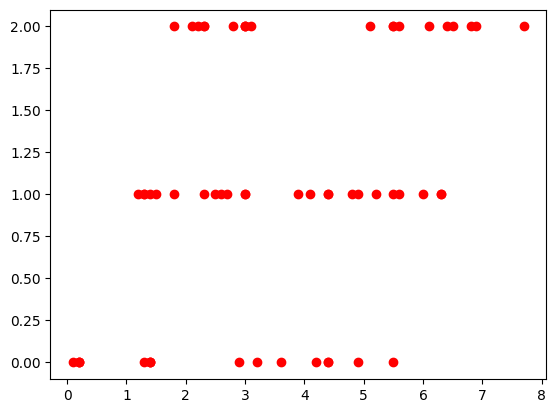

In [75]:
nbc: NaiveBayes = NaiveBayes()
nbc.build_classifier(x_train, y_train)

predictions = [nbc.predict(sample) for sample in x_test]
accuracy = np.mean(predictions == y_test)

print(f"Naive Bayes Accuracy: {accuracy * 100:.2f}%")
plt.plot(x_test, predictions, 'ro')
plt.show()

### Gaussian Naive Bayes Classificator

Accuracy:  1.0


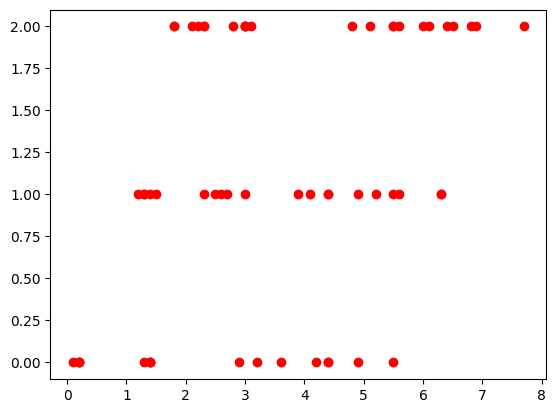

In [76]:
gnbc: GaussianNaiveBayes = GaussianNaiveBayes()
gnbc.build_classifier(x_train, y_train)

predictions = [gnbc.predict(sample) for sample in x_test]
accuracy = np.mean(predictions == y_test)

print(f"Gaussian Naive Bayes Accuracy: {accuracy * 100:.2f}%")
plt.plot(x_test, predictions, 'ro')
plt.show()

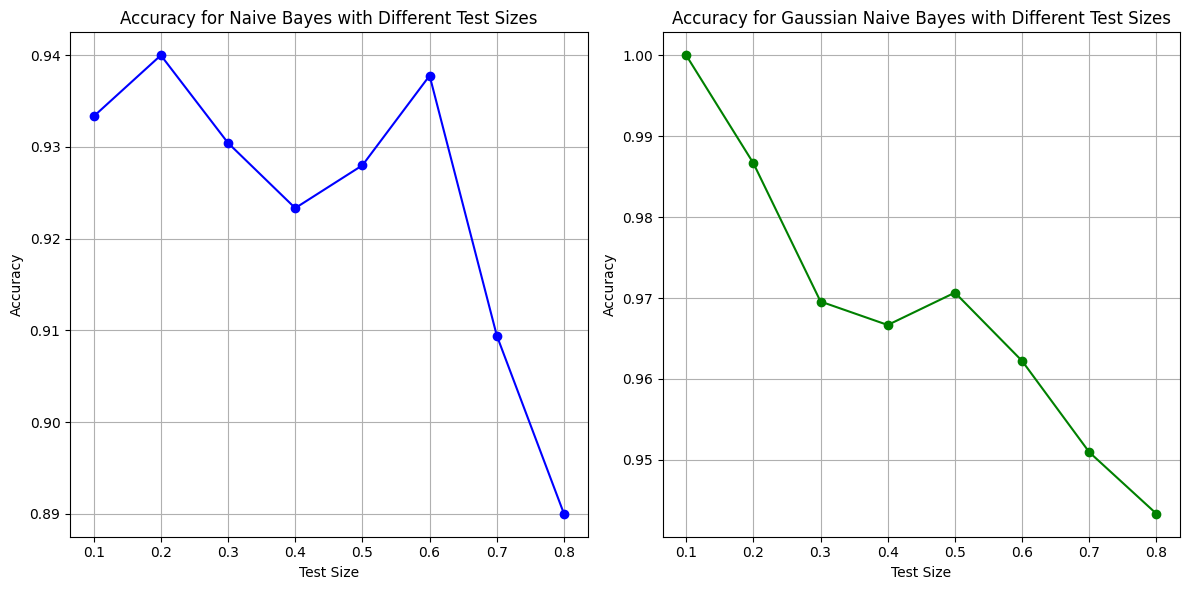

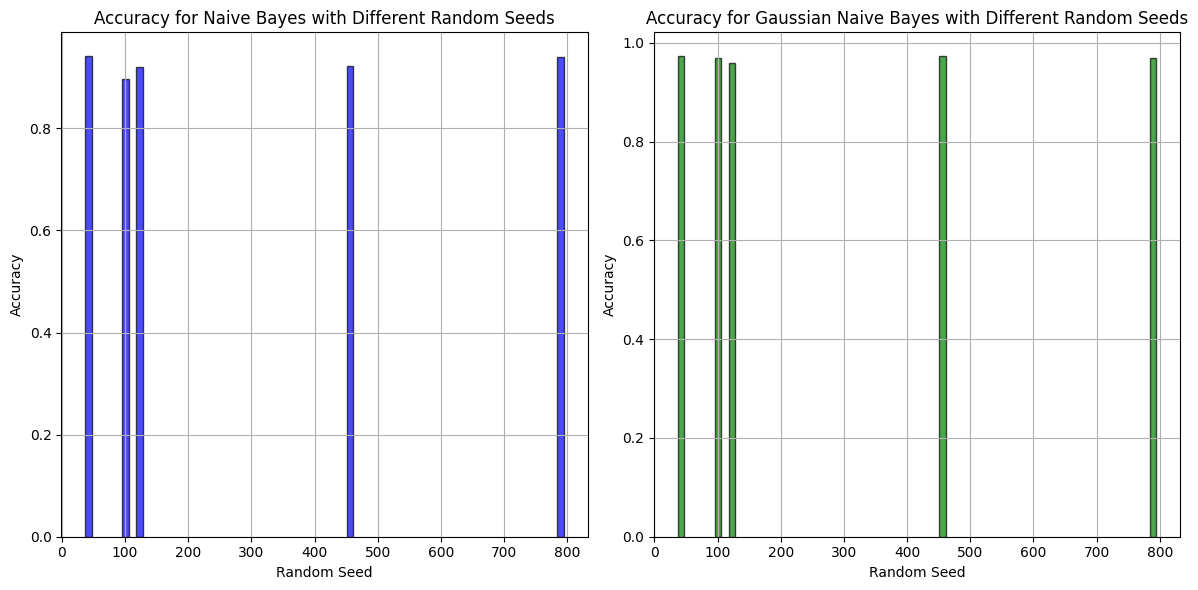

In [77]:
def evaluate_model_for_different_params(model: BayesSkeleton, test_sizes=None, random_seeds=None, fixed_param=None, param_type=None):
    accuracies = []

    if param_type == 'test_size':
        for test_size in test_sizes:
            accs = []
            for random_seed in random_seeds:
                x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_seed)
                classifier = model()
                classifier.build_classifier(x_train, y_train)
                classifier_predictions = [classifier.predict(sample) for sample in x_test]
                classifier_accuracy = np.mean(classifier_predictions == y_test)
                accs.append(classifier_accuracy)
            accuracies.append(np.mean(accs))

    elif param_type == 'random_seed':
        for random_seed in random_seeds:
            accs = []
            for test_size in test_sizes:
                x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_seed)
                classifier = model()
                classifier.build_classifier(x_train, y_train)
                classifier_predictions = [classifier.predict(sample) for sample in x_test]
                classifier_accuracy = np.mean(classifier_predictions == y_test)
                accs.append(classifier_accuracy)
            accuracies.append(accs)

    return accuracies

test_sizes = np.arange(0.1, 0.9, 0.1)
random_seeds = sorted([42, 123, 456, 789, 101])

nbc_accuracies_test_size = evaluate_model_for_different_params(NaiveBayes, test_sizes=test_sizes, random_seeds=random_seeds, param_type='test_size')
gnbc_accuracies_test_size = evaluate_model_for_different_params(GaussianNaiveBayes, test_sizes=test_sizes, random_seeds=random_seeds, param_type='test_size')

nbc_accuracies_random_seed = evaluate_model_for_different_params(NaiveBayes, test_sizes=test_sizes, random_seeds=random_seeds, param_type='random_seed')
gnbc_accuracies_random_seed = evaluate_model_for_different_params(GaussianNaiveBayes, test_sizes=test_sizes, random_seeds=random_seeds, param_type='random_seed')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(test_sizes, nbc_accuracies_test_size, marker='o', label="Naive Bayes", color='b')
plt.title("Accuracy for Naive Bayes with Different Test Sizes")
plt.xlabel("Test Size")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(test_sizes, gnbc_accuracies_test_size, marker='o', label="Gaussian Naive Bayes", color='g')
plt.title("Accuracy for Gaussian Naive Bayes with Different Test Sizes")
plt.xlabel("Test Size")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

nbc_accuracies_random_seed_mean = [np.mean(accs) for accs in nbc_accuracies_random_seed]
gnbc_accuracies_random_seed_mean = [np.mean(accs) for accs in gnbc_accuracies_random_seed]

plt.subplot(1, 2, 1)
plt.bar(random_seeds, nbc_accuracies_random_seed_mean, color='b', alpha=0.7, edgecolor='black', width=10)
plt.title("Accuracy for Naive Bayes with Different Random Seeds")
plt.xlabel("Random Seed")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(random_seeds, gnbc_accuracies_random_seed_mean, color='g', alpha=0.7, edgecolor='black', width=10)
plt.title("Accuracy for Gaussian Naive Bayes with Different Random Seeds")
plt.xlabel("Random Seed")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()